## Loading of Miller ECoG data of motor imagery

includes some visualizations

In [2]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 24.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.

In [4]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper:

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior.

Both experiments:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV).
* `dat['locs`]`: 3D electrode positions on the brain surface

In [5]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [6]:
# quick way to get broadband power in time-varying windows(dat1)
from scipy import signal

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [100], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [7]:
# quick way to get broadband power in time-varying windows(dat2)
from scipy import signal

# pick subject 0 and experiment 1 (imagery movements)
dat2 = alldat[0][1]

# V is the voltage data
V2 = dat2['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [100], btype='high', fs=1000)
V2 = signal.filtfilt(b, a, V2, 0)

# compute smooth envelope of this signal = approx power
V2 = np.abs(V2)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V2 = signal.filtfilt(b, a, V2, 0)

# normalize each channel so its mean power is 1
V2 = V2/V2.mean(0)

In [8]:
# average the broadband power across all tongue and hand and total trials(real)
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 3000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 3000, nchan))

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)
V1_Tot = V_epochs.mean(0)

In [21]:
# average the broadband power across all tongue and hand total trials (imagery)
#nt, nchan = V2.shape
#nstim = len(dat2['t_on'])

trange = np.arange(0, 3000)
ts2 = dat2['t_on'][:, np.newaxis] + trange
V2_epochs = np.reshape(V2[ts, :], (nstim, 3000, nchan))

V2_tongue = (V2_epochs[dat2['stim_id'] == 11]).mean(0)
V2_hand = (V2_epochs[dat2['stim_id'] == 12]).mean(0)
V2_Tot = V2_epochs.mean(0)

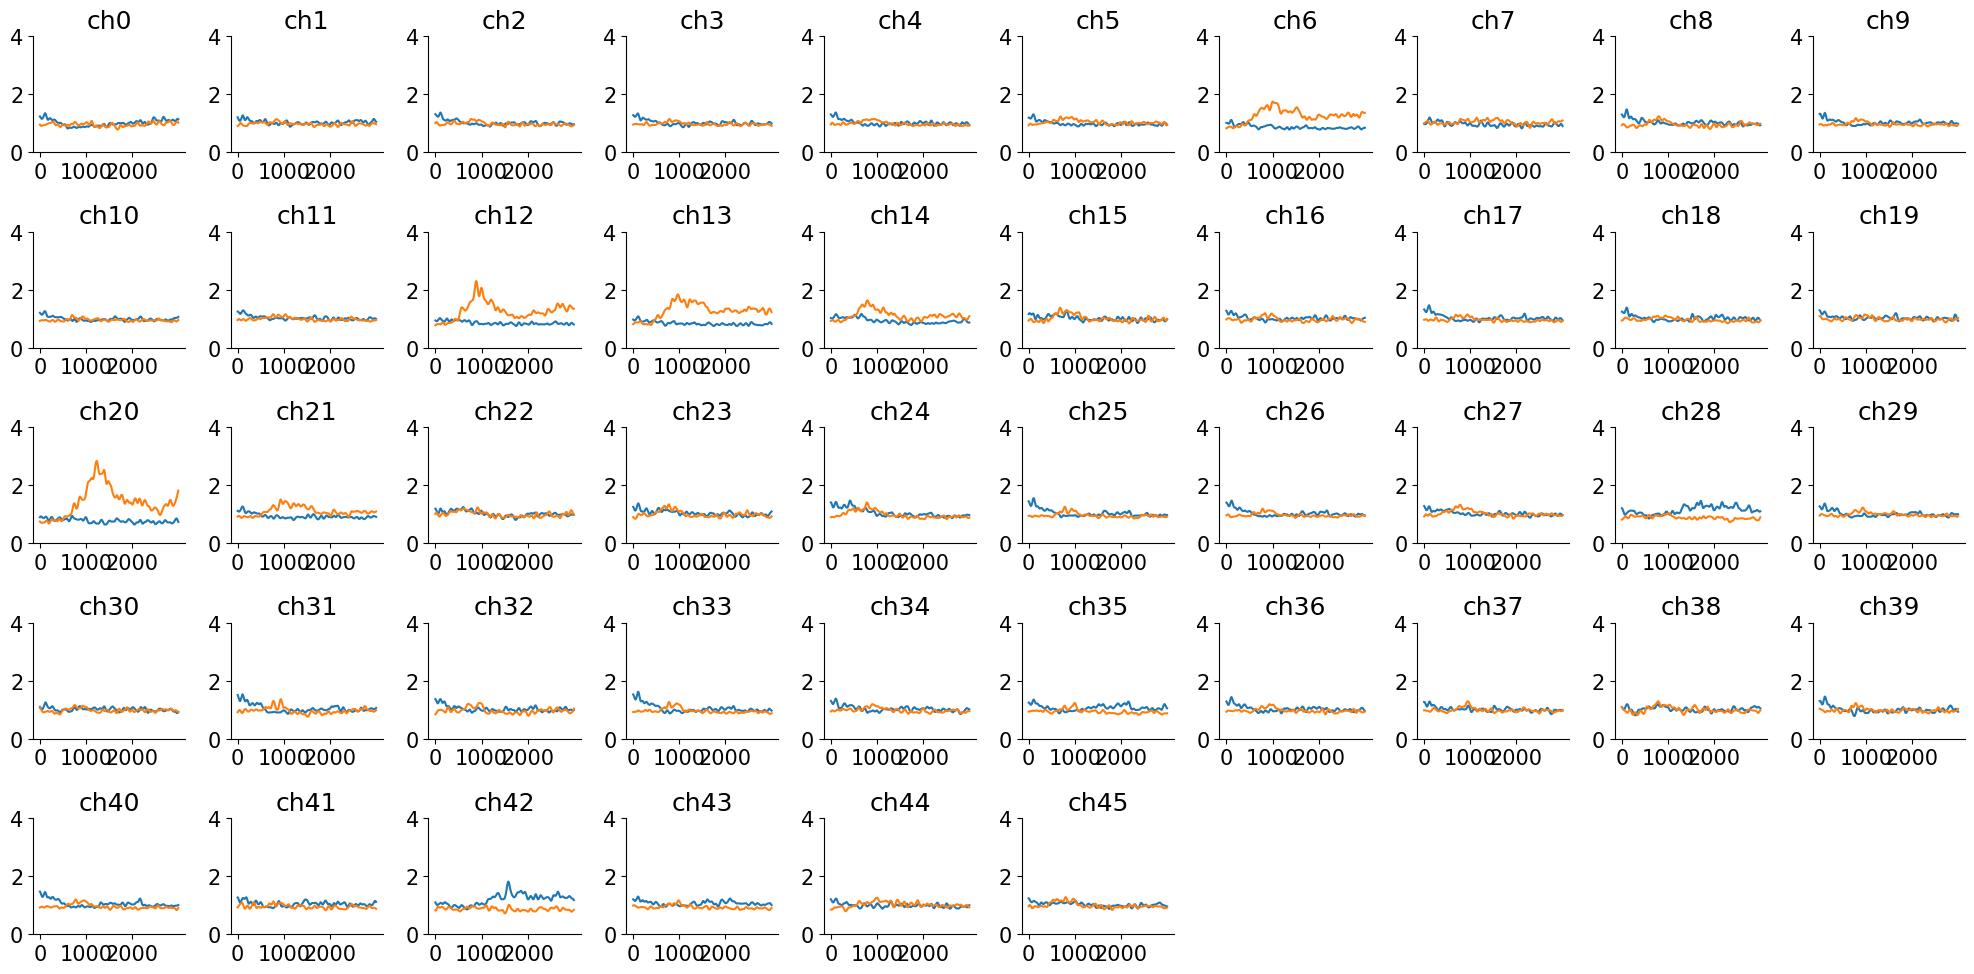

In [10]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
plt.show()

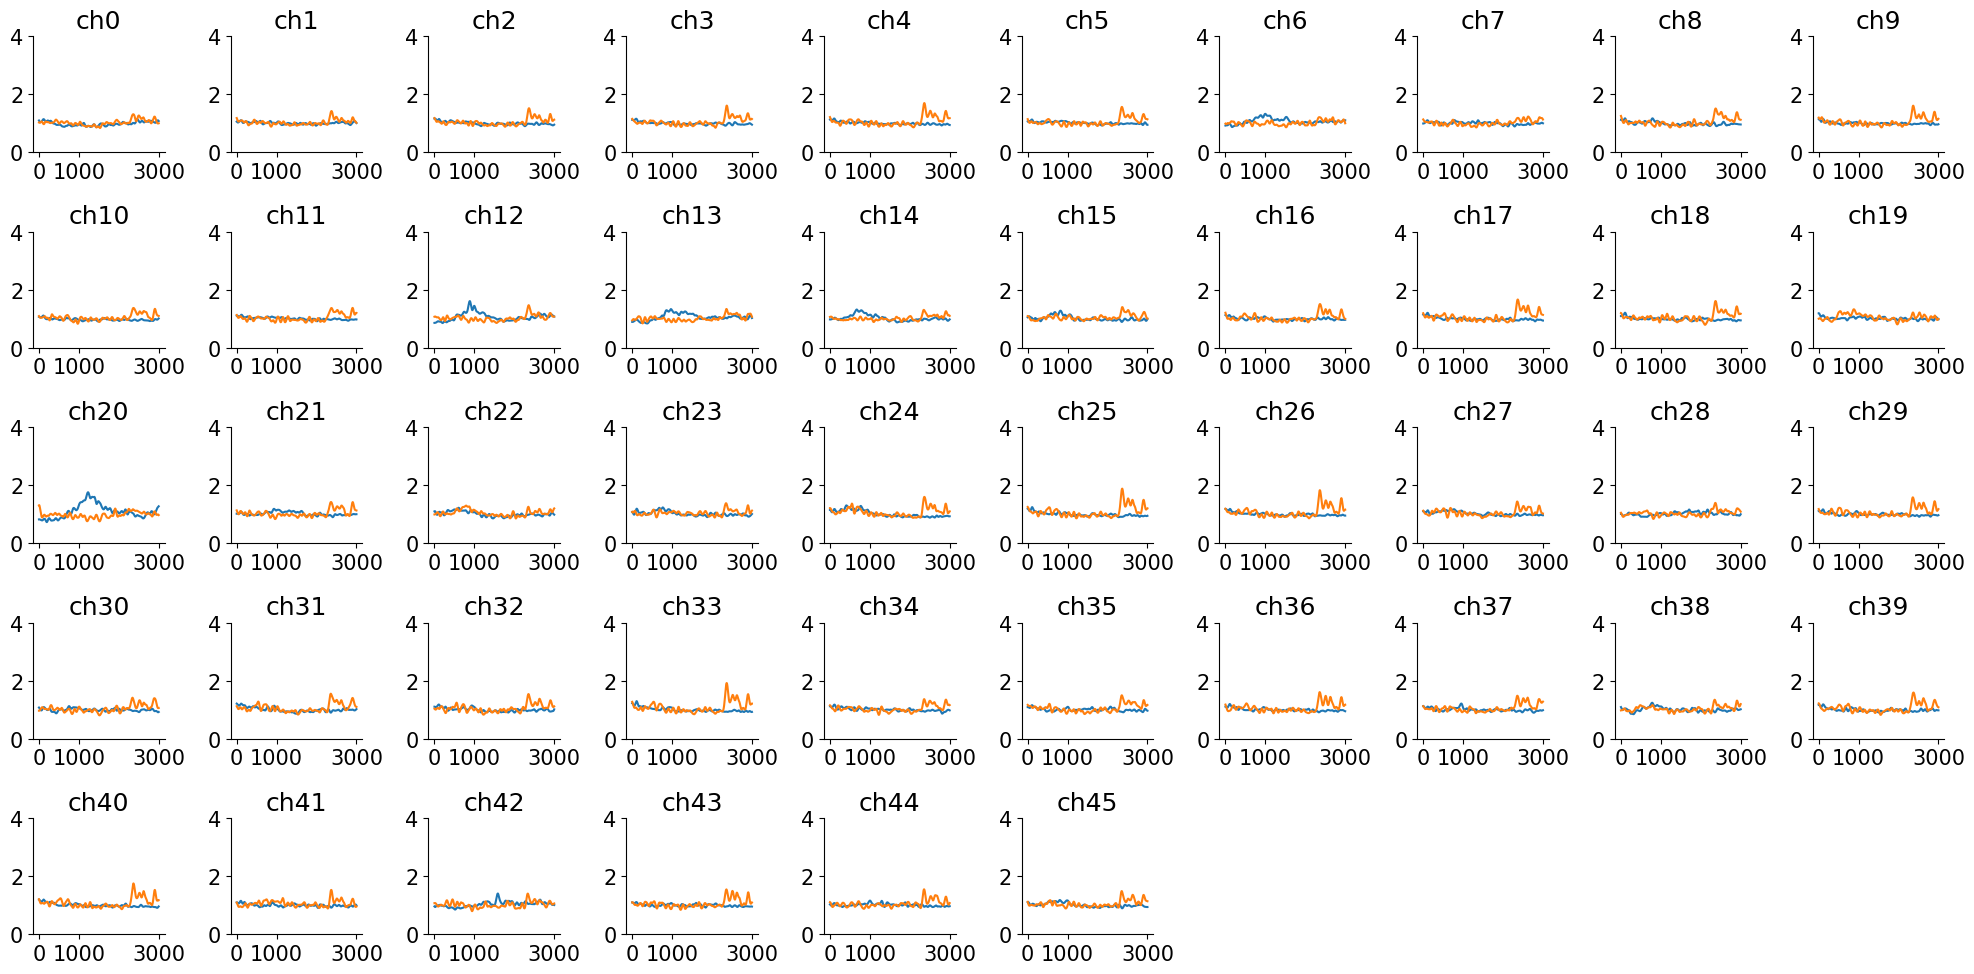

In [11]:
# let's find the electrodes that distinguish real from imagery
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V1_Tot[:, j])
  plt.plot(trange, V2_Tot[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 3000])
  plt.ylim([0, 4])
plt.show()


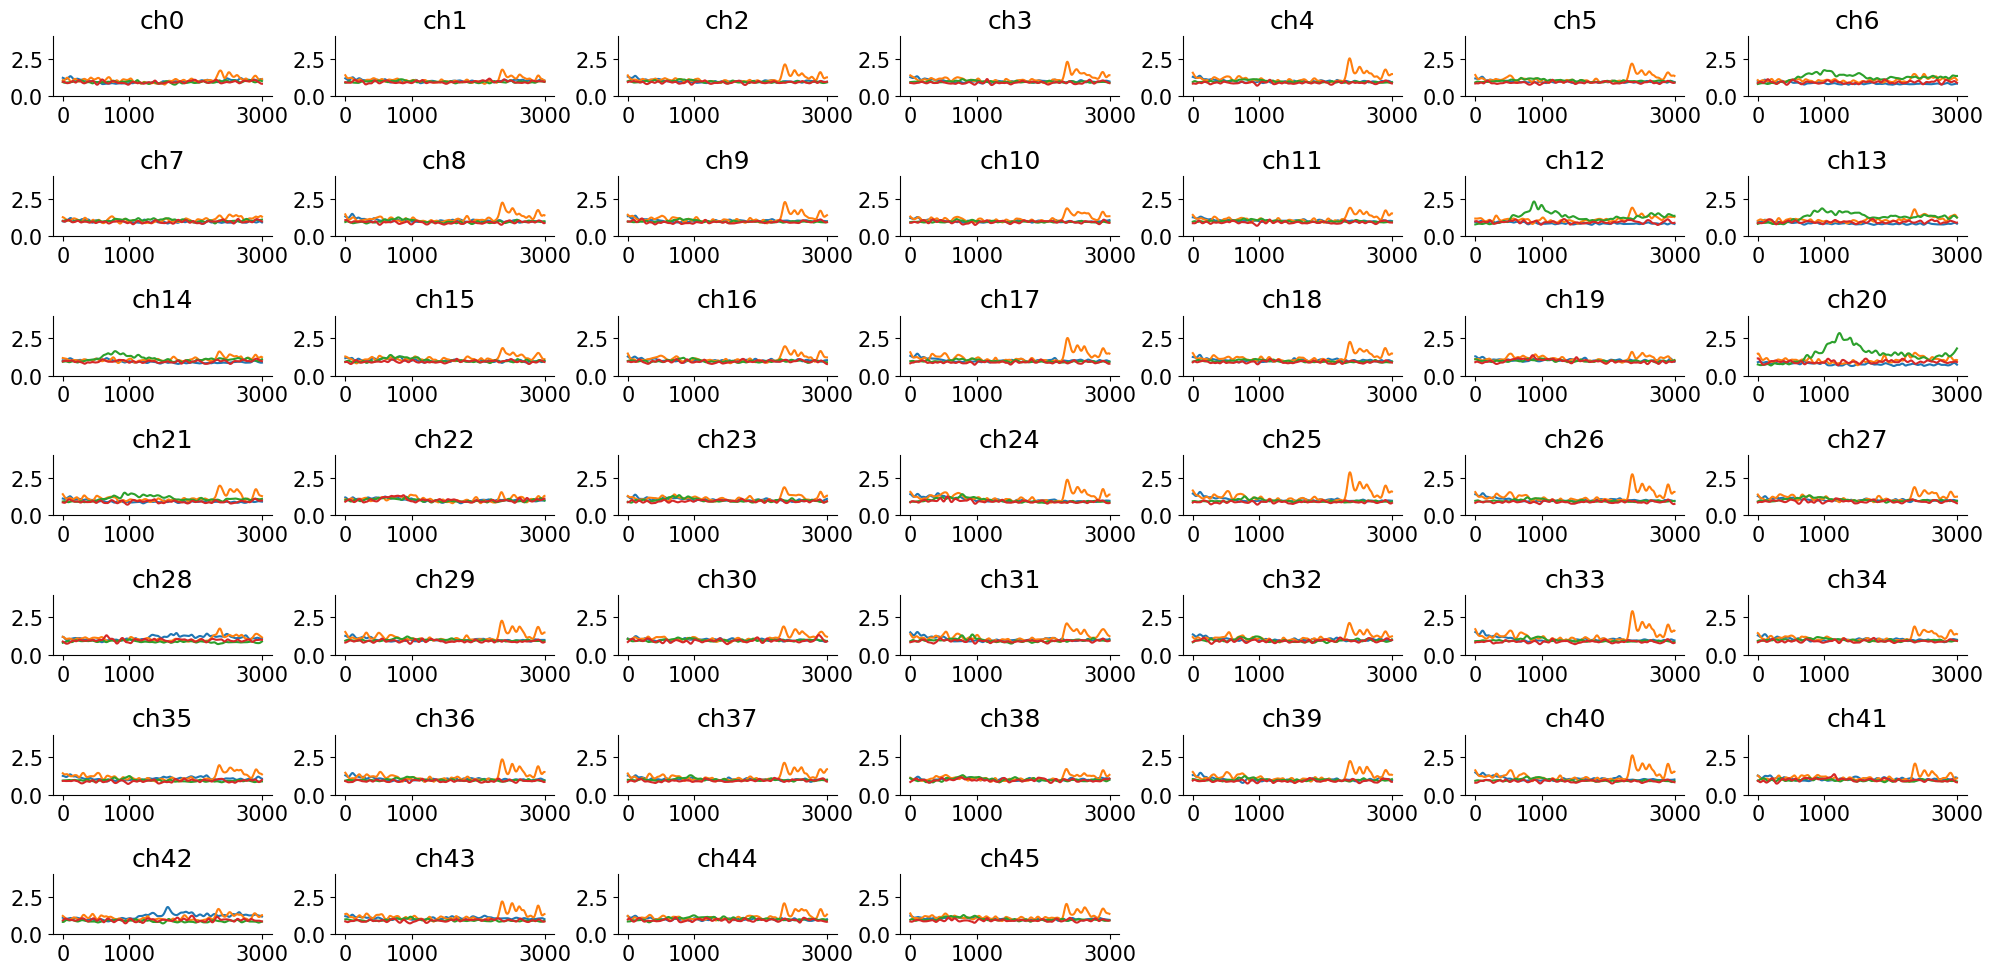

In [12]:
# let's find the electrodes that distinguish real from imagery
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(7, 7, j+1)
  plt.plot(trange, V_tongue[:, j]) #blue
  plt.plot(trange, V2_tongue[:, j]) #orange
  plt.plot(trange, V_hand[:, j]) #green
  plt.plot(trange, V2_hand[:, j]) #red
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 3000])
  plt.ylim([0, 4])
plt.show()


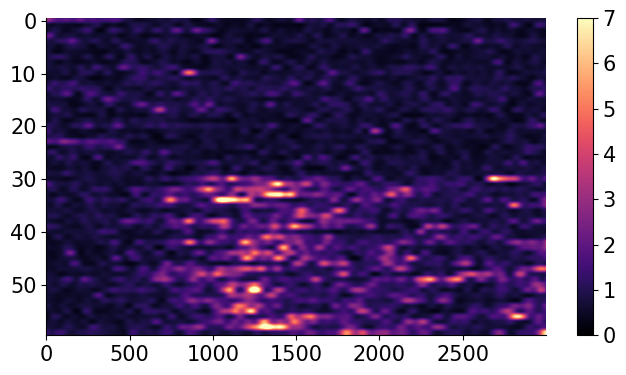

In [13]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 20].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

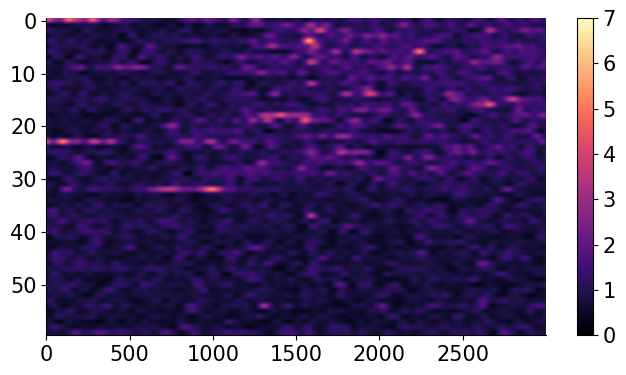

In [14]:
# Electrode 42 seems to respond to tongue movements
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 42].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

In [ ]:
import pandas as pd

df_real =pd.DataFrame(V_epochs[0][:][:])
print(df_real)

In [23]:
!pip install mne --quiet
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 35.9 MB/s eta 0:00:00


In [24]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mne.viz import plot_alignment, snapshot_brain_montage

In [25]:
n_channels = 46
sampling_freq = 1000  # in Hertz
ch_names = [f"ECoG{n}" for n in range(1, 47)]
ch_types = ['ecog']*46
info = mne.create_info(sfreq=sampling_freq , ch_types=ch_types, ch_names=ch_names)

In [51]:
#creating raw data from our data
d1 = dat1['V'].astype('float32')
d1 = d1.T
d1_raw = mne.io.RawArray(d1, info)

d2 = dat2['V'].astype('float32')
d2 = d2.T
d2_raw = mne.io.RawArray(d2, info)

Creating RawArray with float64 data, n_channels=46, n_times=376400
    Range : 0 ... 376399 =      0.000 ...   376.399 secs
Ready.
Creating RawArray with float64 data, n_channels=46, n_times=376600
    Range : 0 ... 376599 =      0.000 ...   376.599 secs
Ready.


In [55]:
#creating events

events1 = []
events2 = []
for i , stim_id in enumerate(dat1['stim_id']):
  events1.append([dat1['t_on'][i] ,  0 , stim_id])

event_id = dict(hand=12 , tongue=11)
events_np1 = np.array(events1)

for i , stim_id in enumerate(dat2['stim_id']):
  events2.append([dat2['t_on'][i] ,  0 , stim_id])

event_id = dict(hand=12 , tongue=11)
events_np2 = np.array(events2)

In [56]:
raw_epochs1 = mne.Epochs(
    raw=d1_raw, tmin=-1.5, tmax=4, events=events_np1, event_id=event_id
)

raw_epochs2 = mne.Epochs(
    raw=d2_raw, tmin=-1.5, tmax=4, events=events_np2, event_id=event_id
)

Not setting metadata
60 matching events found
Setting baseline interval to [-1.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
60 matching events found
Setting baseline interval to [-1.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [57]:
#how one dataset is made

df_real_raw = raw_epochs1.to_data_frame()
df_real_raw['movement_type'] = np.array(['real']*len(df_real_raw))

df_imagery_raw = raw_epochs2.to_data_frame()
df_imagery_raw['movement_type'] = np.array(['imagery']*len(df_imagery_raw))

Using data from preloaded Raw for 60 events and 5501 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 60 events and 5501 original time points ...
0 bad epochs dropped


In [60]:
final_df_raw = pd.concat([df_real_raw, df_imagery_raw], axis=0)
final_df_raw

time condition  epoch          ECoG1          ECoG2          ECoG3  \
0      -1.500      hand      0  406021.682681  391550.337927 -100631.459088   
1      -1.499      hand      0  250626.174868  241159.712927  -95260.365338   
2      -1.498      hand      0  194840.042056  116403.853552  -21774.037213   
3      -1.497      hand      0  105057.327212  -12471.878870  -43990.834088   
4      -1.496      hand      0  -14022.262632  -97707.474573  -93185.170026   
...       ...       ...    ...            ...            ...            ...   
330055  3.996    tongue     59 -409085.195911 -426098.445667  136622.133452   
330056  3.997    tongue     59 -322659.414661 -429516.414417  133326.235014   
330057  3.998    tongue     59 -235257.070911 -451489.070667  118311.586577   
330058  3.999    tongue     59 -137112.539661 -437328.914417   94202.699858   
330059  4.000    tongue     59  -42630.117786 -386547.664417   87000.551421   

                ECoG4         ECoG5         ECoG6          ECoG7  ...  \
0      -184137.936515  6.102275e+05 -1.626891e+05 -148771.538566  ...   
1      -273005.124015  4.337139e+05 -3.382262e+05 -228483.452629  ...   
2      -240290.280265  3.206767e+05 -2.952574e+05  -64657.463859  ...   
3      -280573.483390  1.392803e+05 -3.955992e+05  -73013.558219  ...   
4      -414362.545890 -9.527784e+04 -4.246520e+05  -60590.996574  ...   
...               ...           ...           ...            ...  ...   
330055  128811.875000  1.974565e+06  1.675865e+06  803170.373327  ...   
330056  109890.976562  2.045855e+06  1.761802e+06  858590.295202  ...   
330057   80960.312500  2.055620e+06  1.812584e+06  864449.670202  ...   
330058   52212.753906  2.044878e+06  1.849693e+06  834664.513952  ...   
330059   49099.960937  2.033159e+06  1.893638e+06  858590.295202  ...   

              ECoG38         ECoG39         ECoG40         ECoG41  \
0       2.039258e+06  177812.169505 -295637.786428  423621.567347   
1       2.004101e+06  211137.364818 -355208.098928  387732.895472   
2       1.982617e+06  254472.325755 -319563.567678  412391.098597   
3       1.939648e+06  268632.482005 -389631.927053  316687.973597   
4       1.876172e+06  271318.028880 -449690.520803  185828.598597   
...              ...            ...            ...            ...   
330055  5.016875e+05 -144413.681288  685682.544543 -820577.856543   
330056  5.007109e+05 -120732.040663  681288.013293 -819601.294043   
330057  4.711699e+05  -95585.556288  667127.857043 -836691.137793   
330058  4.357695e+05  -56400.985975  670545.825793 -846945.044043   
330059  4.191679e+05   11622.695666  698866.138293 -808859.106543   

              ECoG42        ECoG43        ECoG44        ECoG45        ECoG46  \
0      -1.625691e+06  6.266300e+05  1.645199e+06  1.253136e+06 -5.177294e+04   
1      -1.814168e+06  6.168644e+05  1.521176e+06  1.219933e+06 -1.026305e+05   
2      -1.983113e+06  6.202823e+05  1.454770e+06  1.214074e+06 -1.140135e+05   
3      -2.170613e+06  5.304386e+05  1.311215e+06  1.169152e+06 -1.376685e+05   
4      -2.334675e+06  2.911808e+05  1.212582e+06  1.096886e+06 -1.623686e+05   
...              ...           ...           ...           ...           ...   
330055 -1.976275e+05  6.827860e+05  5.280461e+04  3.780068e+05  2.226979e+06   
330056 -2.125201e+05  7.562723e+05  3.351750e+04  3.594521e+05  2.258229e+06   
330057 -2.742876e+05  8.387918e+05 -1.738582e+04  3.257607e+05  2.277760e+06   
330058 -3.314165e+05  9.227762e+05 -4.704891e+04  3.018349e+05  2.279713e+06   
330059 -3.660845e+05  1.000901e+06 -2.702938e+04  3.150185e+05  2.281666e+06   

        movement_type  
0                real  
1                real  
2                real  
3                real  
4                real  
...               ...  
330055        imagery  
330056        imagery  
330057        imagery  
330058        imagery  
330059        imagery  

[660120 rows x 50 columns]